<a href="https://colab.research.google.com/github/amedyukhina/AgrifieldNet/blob/main/agrinet_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AgrifieldNet India Competition

## Install and import dependencies


In [1]:
%%writefile requirements.txt

pandas==1.3.5
scikit-learn==1.0.2
tqdm==4.64.0
rasterio==1.2.0
numpy==1.21.6
radiant_mlhub==0.4.1
torch==1.12.1
torchvision==0.13.1
scikit-image==0.18.3
matplotlib==3.2.2
pillow==7.1.2
monai==0.9.1

Overwriting requirements.txt


In [2]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import time
import json
import getpass
import rasterio
import numpy as np
import pandas as pd
from tqdm import tqdm
from radiant_mlhub import Dataset
import tarfile
import shutil
import numpy as np
import pandas as pd
import torch
import torch.utils.data
from torch import nn
from skimage import io
from torchvision import transforms as torch_transforms
from torchvision import models
import pylab as plt
from PIL import Image
from skimage.segmentation import mark_boundaries
from monai.networks.layers import Norm
from monai.networks.nets import UNet
from monai.losses import DiceLoss, DiceCELoss, MaskedDiceLoss
from monai.metrics import DiceMetric
from google.colab import drive

## Specify global parameters

In [4]:
drive.mount('/content/gdrive')
path = 'gdrive/MyDrive/Colab Notebooks/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
random_seed = 42

train_df_path = 'train_data.csv'

# BAND_NAMES = ['B02', 'B03', 'B04', 'B05', 'B08', 'B11', 'B12']
# DEL_BANDS = ['B08']

BAND_NAMES = ['B01', 'B02', 'B03', 'B04','B05', 'B06', 'B07', 
              'B08','B8A', 'B09', 'B11', 'B12']

# ADD_IND_BANDS = [['B08', 'B03'],
#                  ['B08', 'B11'],
#                  ['B11', 'B12'],
#                  ['B08', 'B04']]

# DEL_INDS = [4]

# ADD_INDS = [[4, 1],
#             [4, 5],
#             [5, 6],
#             [4, 2]]

In [6]:
np.random.seed(random_seed)

## Download data from MLHUB


In [7]:
collection_name = 'ref_agrifieldnet_competition_v1'
data_dir = 'data'
# data_dir = path + collection_name

source_collection = f'{collection_name}_source'
train_label_collection = f'{collection_name}_labels_train'
test_label_collection = f'{collection_name}_labels_test'

In [8]:
if not os.path.exists(data_dir):
  os.environ['MLHUB_API_KEY'] =  getpass.getpass(prompt="MLHub API Key: ")

  dataset = Dataset.fetch(collection_name)
  dataset.download(output_dir=data_dir)
  for fn in os.listdir(data_dir):
    with tarfile.open(os.path.join(data_dir, fn)) as f:
      f.extractall(data_dir + '/') 
    os.remove(os.path.join(data_dir, fn))
else:
  print("Dataset already exists")

Dataset already exists


## Prepare Training data


### Create training dataframe

In [9]:
train_paths = os.listdir(os.path.join(data_dir, train_label_collection))
train_ids = [fn.split('_')[-1] for fn in train_paths if 'labels_train' in fn]

field_paths = [f'{data_dir}/{train_label_collection}/{train_label_collection}_{i}/field_ids.tif' 
               for i in train_ids]
label_paths = [f'{data_dir}/{train_label_collection}/{train_label_collection}_{i}/raster_labels.tif' 
               for i in train_ids]
source_paths = [f'{data_dir}/{source_collection}/{source_collection}_{i}/' 
               for i in train_ids]

In [10]:
train_data = pd.DataFrame(np.array([train_ids, field_paths, label_paths, source_paths]).transpose(), 
                          columns=['folder_id', 'field_path', 'label_path', 'source_path'])
train_data.head()

,folder_id,field_path,label_path,source_path
0,b7609,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...
1,4a400,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...
2,d6192,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...
3,d6606,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...
4,f4e9a,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_labels_tr...,data/ref_agrifieldnet_competition_v1_source/re...


## Extract band mean and std

In [11]:
source_paths = [fn for fn in os.listdir(os.path.join(data_dir, 
                                                     source_collection)) 
if not fn.endswith('json')]

In [12]:
means = []
stds = []
for source_path in tqdm(source_paths):
  m = []
  s = []
  for band in BAND_NAMES:
    with rasterio.open(os.path.join(data_dir, source_collection, source_path) + rf"/{band}.tif") as src:
      img = src.read()[0]
      m.append(np.mean(img))
      s.append(np.std(img))
  means.append(m)
  stds.append(s)
means = np.array(means).mean(0)
stds = np.array(stds).mean(0)

100%|██████████| 1217/1217 [00:53<00:00, 22.83it/s]



## Extract field-crop data

In [13]:
def extract_field_crop_data(data):
  field_ids = []
  crop_type = []
  field_area = []
  field_max_dim = []
  field_center_x = []
  field_center_y = []
  label_paths = []
  field_paths = []
  source_paths = []

  for i in tqdm(range(len(data))):
      with rasterio.open(data['field_path'].iloc[i]) as src:
          field_data = src.read()[0]
      with rasterio.open(data['label_path'].iloc[i]) as src:
          crop_data = src.read()[0]

      for field_id in np.unique(field_data)[1:]:
          ind = np.where(field_data == field_id)
          field_ids.append(field_id)
          crop_type.append(np.unique(crop_data[ind])[-1])
          field_area.append(len(ind[0]))
          field_max_dim.append(np.max(np.array(ind).max(1) - np.array(ind).min(1) + 1))
          field_center_y.append(np.mean(ind[0]))
          field_center_x.append(np.mean(ind[1]))
          label_paths.append(data['label_path'].iloc[i])
          field_paths.append(data['field_path'].iloc[i])
          source_paths.append(data['source_path'].iloc[i])

  df = pd.DataFrame(np.array([field_ids, crop_type, field_area, 
                              field_max_dim, field_center_x, 
                              field_center_y]).transpose(),
                    columns=['field_id', 'crop_type', 'field_area', 
                            'field_max_dim', 'center_x', 'center_y'])
  df['label_path'] = label_paths
  df['field_path'] = field_paths
  df['source_path'] = source_paths
  return df

In [14]:
df = extract_field_crop_data(train_data)

100%|██████████| 1165/1165 [00:07<00:00, 164.35it/s]


In [15]:
crop_labels = np.unique(df['crop_type'])
df['crop_ind'] = df['crop_type'].apply(lambda x: np.where(crop_labels == x)[0][0])

In [16]:
(df['crop_type'] == crop_labels[df['crop_ind']]).unique()

array([ True])

In [17]:
maxdim = df['field_max_dim'].max()
maxdim

54.0

In [18]:
size = 16

### Split the data into train and validation

In [19]:
val_fraction = 0.2

In [20]:
np.random.seed(random_seed)
df_train = []
df_val = []
for crop in df['crop_type'].unique():
    cur_df = df[df['crop_type'] == crop].reset_index(drop=True)
    unique_field_ids = cur_df['field_id'].unique()
    ind = np.arange(len(unique_field_ids))
    np.random.shuffle(ind)
    n_val = int(round(val_fraction * len(ind)))
    df_val.append(cur_df[cur_df['field_id'].isin(unique_field_ids[ind[:n_val]])])
    df_train.append(cur_df[cur_df['field_id'].isin(unique_field_ids[ind[n_val:]])])
df_train = pd.concat(df_train, ignore_index=True)
df_val = pd.concat(df_val, ignore_index=True)

In [21]:
df_train = df_train[df_train['field_area'] >= 5].reset_index(drop=True)
df_val = df_val[df_val['field_area'] >= 5].reset_index(drop=True)

In [22]:
n_fields = np.array(df_train.groupby('crop_type').count()['field_id'])
weights = np.max(n_fields) / n_fields
crop_labels, n_fields, weights

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  8.,  9., 13., 14., 15., 16., 36.]),
 array([1677,  809,   80, 1264,   18,  135,   37,  238,   51,   11,   33,
          12,   97]),
 array([  1.        ,   2.07292954,  20.9625    ,   1.32674051,
         93.16666667,  12.42222222,  45.32432432,   7.04621849,
         32.88235294, 152.45454545,  50.81818182, 139.75      ,
         17.28865979]))

In [23]:
loss_weights = np.zeros(int(crop_labels.max()) + 1)
loss_weights[list(np.int_(crop_labels))] = weights
loss_weights

array([  0.        ,   1.        ,   2.07292954,  20.9625    ,
         1.32674051,  93.16666667,  12.42222222,   0.        ,
        45.32432432,   7.04621849,   0.        ,   0.        ,
         0.        ,  32.88235294, 152.45454545,  50.81818182,
       139.75      ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
        17.28865979])

In [24]:
df_train['weight'] = df_train['crop_type'].apply(lambda x: loss_weights[int(x)])
df_val['weight'] = df_val['crop_type'].apply(lambda x: loss_weights[int(x)])

## Extract labels

In [25]:
with open(f'{data_dir}/{train_label_collection}/{train_label_collection}'
          f'_{train_data.iloc[0]["folder_id"]}/stac.json') as ll:
    label_json = json.load(ll)

In [26]:
crop_dict = {asset.get('values')[0]:asset.get('summary') 
  for asset in label_json['assets']['raster_labels']['file:values']}
crop_dict

{1: 'Wheat',
 2: 'Mustard',
 3: 'Lentil',
 4: 'No Crop',
 6: 'Sugarcane',
 8: 'Garlic',
 15: 'Potato',
 5: 'Green pea',
 16: 'Bersem',
 14: 'Coriander',
 13: 'Gram',
 9: 'Maize',
 36: 'Rice'}

## Specify Data Loading pipeline

### Specify the Dataset

In [27]:

class AgriDataset(torch.utils.data.Dataset):

  def __init__(self, df, transforms=None, 
               band_names=BAND_NAMES, size=16,
               means=None, stds=None):
    self.df = df
    self.transforms = transforms
    self.band_names = band_names
    self.size = size
    self.means = means
    self.stds = stds

  def __getitem__(self, index):
    imgs = []
    for band in self.band_names:
      source_fn = rf"{self.df.iloc[index]['source_path']}{band}.tif"
      with rasterio.open(source_fn) as src:
        imgs.append(src.read()[0].astype(np.float64))
    
    label = torch.tensor(self.df.iloc[index]['crop_ind'], dtype=torch.int64)
    field_id = torch.tensor(self.df.iloc[index]['field_id'], dtype=torch.int64)
    imgs = np.array(imgs)

    with rasterio.open(self.df.iloc[index]['field_path']) as src:
      fields = src.read()[0].astype(np.int64)
      imgs = np.concatenate([imgs, fields.reshape((1,) + fields.shape)])

    # z-scoring of the data
    if self.means is not None and self.stds is not None:
      imgs[:len(self.means)] = (imgs[:len(self.means)] - self.means.reshape(-1,1,1)) / self.stds.reshape(-1,1,1)
    else:
      imgs[:len(self.means)] = imgs[:len(self.means)] / 255.

    # pad the image
    hs = int(self.size/2)
    imgs = np.pad(imgs, ((0, 0), (hs, hs), (hs, hs)))
    imgs = torch.tensor(imgs).float()
    imgs[-1] = (imgs[-1] == field_id)*1

    # crop 
    ind = [int(self.df.iloc[index]['center_y'] + hs), 
           int(self.df.iloc[index]['center_x'] + hs)]
    imgs = imgs[:, ind[0]-hs:ind[0]+hs, ind[1]-hs:ind[1]+hs]
      
    # apply transforms
    if self.transforms:
      imgs = self.transforms(imgs)

    return imgs[:-1].float(), imgs[-1], label, field_id
    

  def __len__(self):
    return len(self.df)

### Specify transforms

In [28]:
from torchvision.transforms.functional import InterpolationMode
train_transforms = torch_transforms.Compose([
        torch_transforms.RandomHorizontalFlip(),
        torch_transforms.RandomVerticalFlip(),
        # torch_transforms.RandomRotation(degrees=30),
        # torch_transforms.RandomRotation(degrees=30,
        #                                 interpolation=InterpolationMode.BILINEAR),
        torch_transforms.RandomRotation(degrees=90),
    ])

validation_transforms = torch_transforms.Compose([
        torch_transforms.RandomHorizontalFlip(),
        torch_transforms.RandomVerticalFlip(),
    ])

### Pre-crop the data

In [29]:
cropped_path = 'data_cropped'

In [30]:
cropped_path = 'data_cropped'
df_val['data_path'] = [rf"{cropped_path}/{df_val['field_id'].iloc[i]}_{i}.tif" 
                       for i in range(len(df_val))]
df_train['data_path'] = [rf"{cropped_path}/{df_train['field_id'].iloc[i]}_{i}.tif" 
                       for i in range(len(df_train))]

In [31]:
def save_cropped(df, ds):
  for i in tqdm(range(len(df))):
    if not os.path.exists(df['data_path'].iloc[i]):
      img, mask, _, _ = ds[i]
      x = np.concatenate([img.numpy(), mask.unsqueeze(0).numpy()])
      io.imsave(df['data_path'].iloc[i], x)

In [32]:
os.makedirs(cropped_path, exist_ok=True)
 
ds = AgriDataset(df_val, size=size,
                means=means, stds=stds
                )
save_cropped(df_val, ds)
ds = AgriDataset(df_train, size=size,
              means=means, stds=stds
              )
save_cropped(df_train, ds)

100%|██████████| 4462/4462 [00:00<00:00, 89301.83it/s]


### Dataset for cropped images

In [33]:
class AgriDatasetCropped(torch.utils.data.Dataset):

  def __init__(self, df, transforms=None):
    self.df = df
    self.transforms = transforms

  def __getitem__(self, index):
    x = io.imread(self.df['data_path'][index])
    x = torch.tensor(x, dtype=torch.float64)
    
    label = torch.tensor(self.df.iloc[index]['crop_ind'], dtype=torch.int64)
    field_id = torch.tensor(self.df.iloc[index]['field_id'], dtype=torch.int64)
      
    # apply transforms
    if self.transforms:
      x = self.transforms(x)

    imgs = x[:-1]
    mask = x[-1]
    return imgs.float(), mask.float(), label, field_id
    

  def __len__(self):
    return len(self.df)

### Test the loaders

In [34]:
batch_size = 256

In [35]:
np.random.seed(random_seed)
torch.manual_seed(random_seed)
sampler_tr = torch.utils.data.WeightedRandomSampler(df_train['weight'], 
                                                    len(df_train))
sampler_val = torch.utils.data.WeightedRandomSampler(df_val['weight'],
                                                     len(df_val))
dl_train0 = torch.utils.data.DataLoader(
    AgriDatasetCropped(df_train, 
                ), 
    shuffle=False, batch_size=batch_size, num_workers=2,
    # sampler=sampler_tr
    )
dl_train = torch.utils.data.DataLoader(
    AgriDatasetCropped(df_train,
                transforms=train_transforms,
                ), 
    shuffle=False, batch_size=batch_size, num_workers=2,
    # sampler=sampler_tr
    )
dl_val = torch.utils.data.DataLoader(
    AgriDatasetCropped(df_val,
                transforms=validation_transforms,
                ), 
    shuffle=False, batch_size=batch_size, num_workers=2,
    # sampler=sampler_val
    )

In [36]:
torch.manual_seed(random_seed)
imgs, masks, labels, _ = next(iter(dl_train))
torch.manual_seed(random_seed)
imgs0, masks0, labels0, _ = next(iter(dl_train0))

In [37]:
imgs.shape, masks.shape, labels.shape

(torch.Size([256, 12, 16, 16]), torch.Size([256, 16, 16]), torch.Size([256]))

In [38]:
ind = 0
s = 3

tensor(3) No Crop


/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


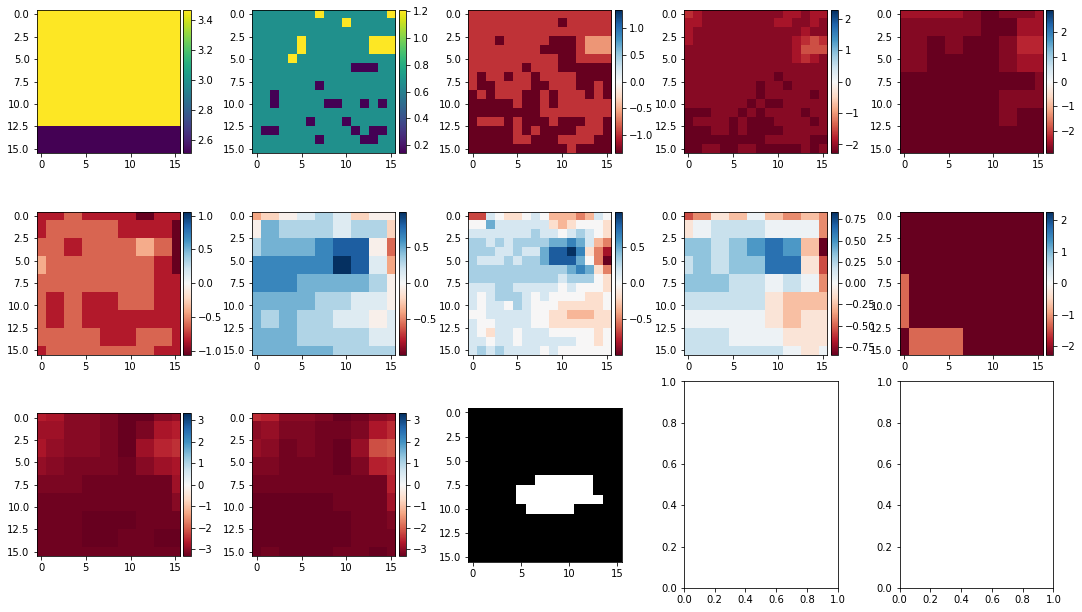

In [39]:
fig, axes = plt.subplots(3, 5, figsize=(s*5, s*3))
print(labels0[ind], crop_dict[crop_labels[labels0[ind].item()]])
for ax, img in zip(axes.ravel(), torch.concat([imgs0[ind], masks0[ind].unsqueeze(0)])):
  plt.sca(ax)
  im = img.numpy()
  io.imshow(im)

tensor(3) No Crop


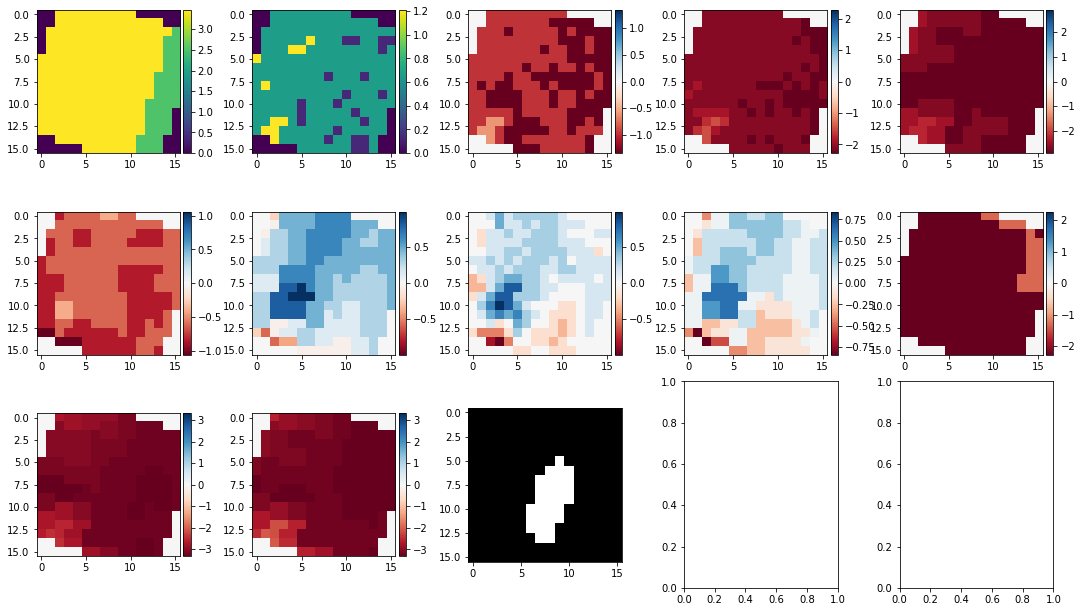

In [40]:
fig, axes = plt.subplots(3, 5, figsize=(s*5, s*3))
print(labels[ind], crop_dict[crop_labels[labels[ind].item()]])
for ax, img in zip(axes.ravel(), torch.concat([imgs[ind], masks[ind].unsqueeze(0)])):
  plt.sca(ax)
  im = img.numpy()
  io.imshow(im)

### Specify the loaders

In [41]:
np.random.seed(random_seed)
torch.manual_seed(random_seed)

dl_train = torch.utils.data.DataLoader(
    AgriDatasetCropped(df_train, 
                transforms=train_transforms,
                ), 
    batch_size=batch_size, num_workers=2,
    drop_last=False,
    sampler=sampler_tr
    )
dl_val = torch.utils.data.DataLoader(
    AgriDatasetCropped(df_val, 
                transforms=validation_transforms,
                ), 
    batch_size=batch_size, num_workers=2,
    shuffle=False,
    drop_last=False,
    sampler=sampler_val
    )

## Specify the training pipeline

### Model and loss

In [42]:
import math

class PositionEmbeddingSine(nn.Module):
    """
    Adapted from https://github.com/facebookresearch/detr/blob/main/models/position_encoding.py
    """

    def __init__(self, num_pos_feats=64, temperature=10000, normalize=False, scale=None):
        super().__init__()
        self.num_pos_feats = num_pos_feats
        self.temperature = temperature
        self.normalize = normalize
        if scale is not None and normalize is False:
            raise ValueError("normalize should be True if scale is passed")
        if scale is None:
            scale = 2 * math.pi
        self.scale = scale

    def forward(self, x):
        not_mask = torch.ones((x.shape[0],) + x.shape[-2:])
        y_embed = not_mask.cumsum(1, dtype=torch.float32).to(x.device)
        x_embed = not_mask.cumsum(2, dtype=torch.float32).to(x.device)
        if self.normalize:
            eps = 1e-6
            y_embed = y_embed / (y_embed[:, -1:, :] + eps) * self.scale
            x_embed = x_embed / (x_embed[:, :, -1:] + eps) * self.scale

        dim_t = torch.arange(self.num_pos_feats, dtype=torch.float32, device=x.device)
        dim_t = self.temperature ** (2 * torch.div(dim_t, 2, rounding_mode='trunc') / self.num_pos_feats)

        pos_x = x_embed[:, :, :, None] / dim_t
        pos_y = y_embed[:, :, :, None] / dim_t
        pos_x = torch.stack((pos_x[:, :, :, 0::2].sin(), pos_x[:, :, :, 1::2].cos()), dim=4).flatten(3)
        pos_y = torch.stack((pos_y[:, :, :, 0::2].sin(), pos_y[:, :, :, 1::2].cos()), dim=4).flatten(3)
        pos = torch.cat((pos_y, pos_x), dim=3).permute(0, 3, 1, 2)
        return pos


In [43]:
class Transformer(nn.Module):

    def __init__(self, hidden_dim, num_classes, nheads=8, num_layers=6):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, 
                                                   nhead=nheads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, 
                                                         num_layers=num_layers)
        
        self.mlp = nn.Sequential(
            nn.Linear(32, 64, bias=True),
            nn.PReLU(),
            nn.Dropout(0.3),
            nn.BatchNorm1d(64),
            nn.Linear(64, 128, bias=True),
            nn.PReLU(),
            nn.Dropout(0.3),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64, bias=True),
        )

        self.class_embed = nn.Linear(hidden_dim, num_classes)

        # spatial positional encodings
        self.position_encodings = PositionEmbeddingSine(torch.div(hidden_dim, 
                                                                  2, 
                                                                  rounding_mode='trunc'),
                                                        normalize=True)

    def forward(self, x, mask):
        mask = (1 - mask).flatten(-2, -1).transpose(-1, -2)
        pos = self.position_encodings(x)
        out = self.transformer_encoder((pos + x).flatten(-2, -1).transpose(-1, -2),
                                       src_key_padding_mask=mask)
        class_prob = self.class_embed(out.mean(1))
        return class_prob

In [44]:
net = Transformer(hidden_dim=len(BAND_NAMES), 
                  num_classes=len(crop_labels), nheads=4).cuda()

In [45]:
# loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(weights).float()).cuda()
loss_fn = nn.CrossEntropyLoss().cuda()

### Optimizer and scheduler

In [46]:
lr = 0.0001
weight_decay = 0.0005
epochs = 50
patience = 5
factor = 0.1

In [47]:
optimizer = torch.optim.AdamW(
    params=[{"params": [p for p in net.parameters() if p.requires_grad]}],
            lr=lr, weight_decay=weight_decay
            )
# lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, max_lr=lr, steps_per_epoch=len(dl_train), epochs=epochs
#     )
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=factor, patience=patience
    )

### Training step

In [48]:
def train_epoch(net, loss_fn, dl_train, optimizer, lr_scheduler):
  net.train()
  loss_fn.train()
  epoch_loss = 0
  step = 0
  for imgs, masks, targets, _ in tqdm(dl_train):
    step += 1
    optimizer.zero_grad()
    outputs = net(imgs.cuda(), masks.cuda())
    losses = loss_fn(outputs, targets.cuda())
    losses.backward()
    optimizer.step()
    epoch_loss += losses.item()
    # lr_scheduler.step()
  epoch_loss /= step
  return epoch_loss

### Validation step

In [49]:
def validate_epoch(net, loss_fn, dl_val):
  net.eval()
  loss_fn.eval()
  epoch_loss = 0
  step = 0

  with torch.no_grad():
    for imgs, masks, targets, _ in tqdm(dl_val):
      step += 1
      outputs = net(imgs.cuda(), masks.cuda())
      losses = loss_fn(outputs, targets.cuda())
      epoch_loss += losses.item()
  epoch_loss /= step
  return epoch_loss

## Train the model

In [50]:
model_name = rf'{int(time.time())}_{time.ctime()}'
model_dir = os.path.join(path, 'models', model_name)
os.makedirs(model_dir, exist_ok=True)

In [51]:
%%time
torch.manual_seed(random_seed)
np.random.seed(random_seed)
best_loss = 10**10
train_losses = []
val_losses = []
for epoch in range(epochs):
    # training pass
    train_loss = train_epoch(net, loss_fn, dl_train, optimizer, lr_scheduler)

    # validation pass
    val_loss = validate_epoch(net, loss_fn, dl_val)
    lr_scheduler.step(val_loss)

    # output
    print(f"epoch {epoch + 1} training loss: {train_loss:.4f}; "
          f"validation loss: {val_loss:.4f}; "
          f"lr: {optimizer.param_groups[0]['lr']}")
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if val_loss <= best_loss:
      best_loss = val_loss
      torch.save(net.state_dict(), os.path.join(model_dir, 'best_model.pth'))
      print('saving best model')
    torch.save(net.state_dict(), os.path.join(model_dir, 'last_model.pth'))

100%|██████████| 5/5 [00:01<00:00,  3.26it/s]


epoch 1 training loss: 2.5650; validation loss: 2.5166; lr: 0.0001
saving best model


100%|██████████| 5/5 [00:01<00:00,  3.33it/s]


epoch 2 training loss: 2.4090; validation loss: 2.3763; lr: 0.0001
saving best model


100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


epoch 3 training loss: 2.3102; validation loss: 2.2790; lr: 0.0001
saving best model


100%|██████████| 5/5 [00:01<00:00,  3.45it/s]


epoch 4 training loss: 2.2472; validation loss: 2.2300; lr: 0.0001
saving best model


100%|██████████| 5/5 [00:01<00:00,  3.52it/s]


epoch 5 training loss: 2.2145; validation loss: 2.1806; lr: 0.0001
saving best model


100%|██████████| 5/5 [00:01<00:00,  3.35it/s]


epoch 6 training loss: 2.1962; validation loss: 2.1930; lr: 0.0001


100%|██████████| 5/5 [00:01<00:00,  3.41it/s]


epoch 7 training loss: 2.1822; validation loss: 2.1686; lr: 0.0001
saving best model


100%|██████████| 5/5 [00:01<00:00,  3.36it/s]


epoch 8 training loss: 2.1622; validation loss: 2.1700; lr: 0.0001


100%|██████████| 5/5 [00:01<00:00,  3.40it/s]


epoch 9 training loss: 2.1616; validation loss: 2.1175; lr: 0.0001
saving best model


100%|██████████| 5/5 [00:01<00:00,  3.47it/s]


epoch 10 training loss: 2.1376; validation loss: 2.1343; lr: 0.0001


100%|██████████| 5/5 [00:01<00:00,  3.26it/s]


epoch 11 training loss: 2.1336; validation loss: 2.1498; lr: 0.0001


100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


epoch 12 training loss: 2.1060; validation loss: 2.1141; lr: 0.0001
saving best model


100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


epoch 13 training loss: 2.1046; validation loss: 2.1101; lr: 0.0001
saving best model


100%|██████████| 5/5 [00:01<00:00,  3.36it/s]


epoch 14 training loss: 2.0740; validation loss: 2.0890; lr: 0.0001
saving best model


100%|██████████| 5/5 [00:01<00:00,  3.38it/s]


epoch 15 training loss: 2.0836; validation loss: 2.1260; lr: 0.0001


100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


epoch 16 training loss: 2.0566; validation loss: 2.1012; lr: 0.0001


100%|██████████| 5/5 [00:01<00:00,  3.35it/s]


epoch 17 training loss: 2.0624; validation loss: 2.0993; lr: 0.0001


100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


epoch 18 training loss: 2.0579; validation loss: 2.0943; lr: 0.0001


100%|██████████| 5/5 [00:01<00:00,  3.30it/s]


epoch 19 training loss: 2.0493; validation loss: 2.0864; lr: 0.0001
saving best model


100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


epoch 20 training loss: 2.0295; validation loss: 2.0270; lr: 0.0001
saving best model


100%|██████████| 5/5 [00:01<00:00,  3.31it/s]


epoch 21 training loss: 2.0278; validation loss: 2.0802; lr: 0.0001


100%|██████████| 5/5 [00:01<00:00,  3.19it/s]


epoch 22 training loss: 2.0140; validation loss: 2.0498; lr: 0.0001


100%|██████████| 5/5 [00:01<00:00,  3.48it/s]


epoch 23 training loss: 2.0089; validation loss: 2.0138; lr: 0.0001
saving best model


100%|██████████| 5/5 [00:01<00:00,  3.29it/s]


epoch 24 training loss: 1.9940; validation loss: 2.0370; lr: 0.0001


100%|██████████| 5/5 [00:01<00:00,  3.39it/s]


epoch 25 training loss: 1.9916; validation loss: 2.0577; lr: 0.0001


100%|██████████| 5/5 [00:01<00:00,  3.26it/s]


epoch 26 training loss: 1.9801; validation loss: 2.0527; lr: 0.0001


100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


epoch 27 training loss: 1.9774; validation loss: 2.0369; lr: 0.0001


100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


epoch 28 training loss: 1.9605; validation loss: 2.0316; lr: 0.0001


100%|██████████| 5/5 [00:01<00:00,  3.37it/s]


epoch 29 training loss: 1.9578; validation loss: 2.0144; lr: 1e-05


100%|██████████| 5/5 [00:01<00:00,  3.31it/s]


epoch 30 training loss: 1.9616; validation loss: 2.0067; lr: 1e-05
saving best model


100%|██████████| 5/5 [00:01<00:00,  3.31it/s]


epoch 31 training loss: 1.9456; validation loss: 2.0406; lr: 1e-05


100%|██████████| 5/5 [00:01<00:00,  3.19it/s]


epoch 32 training loss: 1.9565; validation loss: 2.0290; lr: 1e-05


100%|██████████| 5/5 [00:01<00:00,  3.29it/s]


epoch 33 training loss: 1.9482; validation loss: 2.0131; lr: 1e-05


100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


epoch 34 training loss: 1.9327; validation loss: 2.0165; lr: 1e-05


100%|██████████| 5/5 [00:01<00:00,  3.41it/s]


epoch 35 training loss: 1.9391; validation loss: 2.0123; lr: 1e-05


100%|██████████| 5/5 [00:01<00:00,  3.35it/s]


epoch 36 training loss: 1.9380; validation loss: 2.0321; lr: 1.0000000000000002e-06


100%|██████████| 5/5 [00:01<00:00,  3.33it/s]


epoch 37 training loss: 1.9272; validation loss: 2.0858; lr: 1.0000000000000002e-06


100%|██████████| 5/5 [00:01<00:00,  3.35it/s]


epoch 38 training loss: 1.9361; validation loss: 2.0249; lr: 1.0000000000000002e-06


100%|██████████| 5/5 [00:01<00:00,  3.39it/s]


epoch 39 training loss: 1.9366; validation loss: 1.9649; lr: 1.0000000000000002e-06
saving best model


100%|██████████| 5/5 [00:01<00:00,  3.30it/s]


epoch 40 training loss: 1.9384; validation loss: 2.0162; lr: 1.0000000000000002e-06


100%|██████████| 5/5 [00:01<00:00,  3.53it/s]


epoch 41 training loss: 1.9407; validation loss: 2.0205; lr: 1.0000000000000002e-06


100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


epoch 42 training loss: 1.9443; validation loss: 1.9788; lr: 1.0000000000000002e-06


100%|██████████| 5/5 [00:01<00:00,  3.26it/s]


epoch 43 training loss: 1.9521; validation loss: 2.0232; lr: 1.0000000000000002e-06


100%|██████████| 5/5 [00:01<00:00,  3.47it/s]


epoch 44 training loss: 1.9481; validation loss: 2.0411; lr: 1.0000000000000002e-06


100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


epoch 45 training loss: 1.9344; validation loss: 2.0389; lr: 1.0000000000000002e-07


100%|██████████| 5/5 [00:01<00:00,  3.26it/s]


epoch 46 training loss: 1.9512; validation loss: 2.0570; lr: 1.0000000000000002e-07


100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


epoch 47 training loss: 1.9521; validation loss: 2.0285; lr: 1.0000000000000002e-07


100%|██████████| 5/5 [00:01<00:00,  3.50it/s]


epoch 48 training loss: 1.9457; validation loss: 2.0262; lr: 1.0000000000000002e-07


100%|██████████| 5/5 [00:01<00:00,  3.12it/s]


epoch 49 training loss: 1.9374; validation loss: 2.0506; lr: 1.0000000000000002e-07


100%|██████████| 5/5 [00:01<00:00,  3.31it/s]

epoch 50 training loss: 1.9513; validation loss: 2.0427; lr: 1.0000000000000002e-07
CPU times: user 5min 29s, sys: 12.1 s, total: 5min 41s
Wall time: 8min 55s


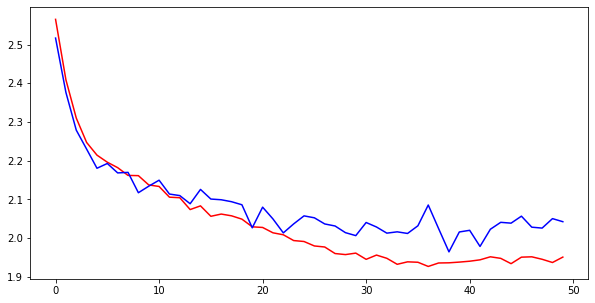

In [52]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses,'r')
plt.plot(val_losses, 'b')

## Set up the loaders and model for evaluation

In [53]:
dl_test = torch.utils.data.DataLoader(
    AgriDatasetCropped(df_val),
    shuffle=False, drop_last=False, batch_size=16, num_workers=2
    )

In [54]:
net.load_state_dict(torch.load(os.path.join(model_dir, 'best_model.pth')))
net.eval();

## Evaluate the model on the validation set

In [55]:
def evaluate(dl_test, net, crop_labels, df_val):
  field_data = []
  outputs = []
  with torch.no_grad():
    for imgs, masks, gt, field_id in tqdm(dl_test):
      output = net(imgs.cuda(), masks.cuda()).softmax(-1).cpu().numpy()
      # output = output[:, np.int_(crop_labels)]
      field_id = field_id.numpy()
      field_data.append(field_id)
      outputs.append(output)
  outputs = np.concatenate(outputs, axis=0)
  outputs = outputs * df_val['field_area'].values.reshape(-1, 1)

  df_out = pd.DataFrame(outputs, columns=crop_labels)
  df_out['field_id'] = df_val['field_id']
  df_out['crop_type'] = df_val['crop_type']
  df_sm = df_out.groupby('field_id').sum().reset_index()
  probs = df_sm[crop_labels].values
  probs = probs / np.sum(probs, axis=1).reshape(-1,1)
  crop_types = df_out.groupby('field_id').mean().reset_index()['crop_type'].values
        
  return probs, np.int_(df_sm['field_id'].values), crop_types

In [56]:
probs, field_ids, gt = evaluate(dl_test, net, crop_labels, df_val)

100%|██████████| 70/70 [00:01<00:00, 41.72it/s]


In [57]:
probs.shape, field_ids.shape, gt.shape

((1079, 13), (1079,), (1079,))

In [58]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)

print(classification_report(gt, np.array(crop_labels)[np.argmax(probs, axis=1)]))

              precision    recall  f1-score   support

         1.0       0.88      0.02      0.03       404
         2.0       0.33      0.01      0.01       194
         3.0       0.03      0.10      0.04        21
         4.0       0.86      0.64      0.74       304
         5.0       0.03      0.40      0.06         5
         6.0       0.11      0.45      0.17        33
         8.0       0.05      0.80      0.10        10
         9.0       0.45      0.81      0.58        58
        13.0       0.04      0.09      0.05        11
        14.0       0.00      0.00      0.00         3
        15.0       0.08      0.12      0.10         8
        16.0       0.00      0.33      0.01         3
        36.0       0.14      0.04      0.06        25

    accuracy                           0.26      1079
   macro avg       0.23      0.29      0.15      1079
weighted avg       0.66      0.26      0.26      1079



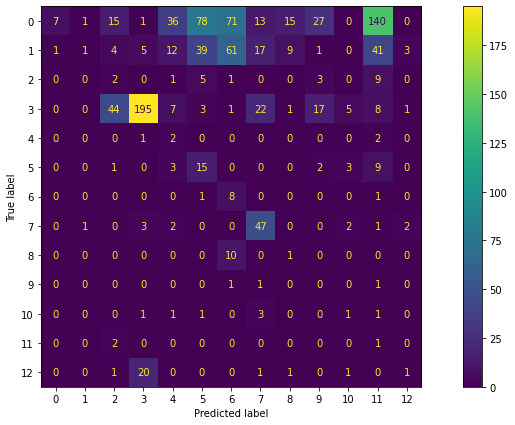

In [59]:
# Confusion matrix
cm = confusion_matrix(gt, np.array(crop_labels)[np.argmax(probs, axis=1)])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(15,7))
disp.plot(ax=ax)
plt.show()

In [60]:
def to_one_hot(x):
    y = np.zeros((x.size, x.max() + 1))
    y[np.arange(x.size), x] = 1
    return y

def cross_entropy(predictions, targets):
    return -np.sum(np.sum(np.log(predictions + 10**(-10)) * targets, axis=1))/len(targets)


In [61]:
# targets = to_one_hot(np.int_([np.where(crop_labels == lb)[0][0] for lb in gt]))
targets = to_one_hot(np.int_(gt))
targets = targets[:, np.where(targets.sum(axis=0) > 0)[0]]

In [62]:
cross_entropy(probs, targets)

2.239808826825256

## Prepare the test dataset

In [63]:
test_paths = os.listdir(os.path.join(data_dir, test_label_collection))
test_ids = [fn.split('_')[-1] for fn in test_paths if 'labels_test' in fn]

field_paths = [f'{data_dir}/{test_label_collection}/{test_label_collection}_{i}/field_ids.tif' 
               for i in test_ids]
label_paths = [f'{data_dir}/{test_label_collection}/{test_label_collection}_{i}/raster_labels.tif' 
               for i in test_ids]
source_paths = [f'{data_dir}/{source_collection}/{source_collection}_{i}/' 
               for i in test_ids]

In [64]:
test_data = pd.DataFrame(np.array([test_ids, field_paths, label_paths, source_paths]).transpose(), 
                          columns=['folder_id', 'field_path', 'label_path', 'source_path'])
test_data.head()

,folder_id,field_path,label_path,source_path
0,53839,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_source/re...
1,baaec,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_source/re...
2,c19b5,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_source/re...
3,67727,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_source/re...
4,e2334,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_labels_te...,data/ref_agrifieldnet_competition_v1_source/re...


In [65]:
def extract_field_crop_data_test(data):
  field_ids = []
  field_center_x = []
  field_center_y = []
  field_paths = []
  source_paths = []
  field_area = []

  for i in tqdm(range(len(data))):
      with rasterio.open(data['field_path'].iloc[i]) as src:
          field_data = src.read()[0]

      for field_id in np.unique(field_data)[1:]:
          ind = np.where(field_data == field_id)
          field_ids.append(field_id)
          field_area.append(len(ind[0]))
          field_center_y.append(np.mean(ind[0]))
          field_center_x.append(np.mean(ind[1]))
          field_paths.append(data['field_path'].iloc[i])
          source_paths.append(data['source_path'].iloc[i])

  df = pd.DataFrame(np.array([field_ids, field_center_x, 
                              field_center_y, field_area]).transpose(),
                    columns=['field_id', 'center_x', 'center_y', 'field_area'])
  df['field_path'] = field_paths
  df['source_path'] = source_paths
  return df

In [66]:
test_df = extract_field_crop_data_test(test_data)
test_df['crop_ind'] = 0
test_df['crop_type'] = 1

100%|██████████| 707/707 [00:02<00:00, 313.07it/s]


## Evaluate the model on the test set

In [67]:
dl_test = torch.utils.data.DataLoader(
    AgriDataset(test_df,
                means=means, stds=stds), shuffle=False, drop_last=False, 
    batch_size=16, num_workers=2
    )

In [68]:
probs, field_ids, _ = evaluate(dl_test, net, crop_labels, test_df)

100%|██████████| 101/101 [00:51<00:00,  1.95it/s]


In [69]:
crop_columns = [crop_dict[key] for key in crop_labels]

output_df = pd.DataFrame(columns=['field_id'] + crop_columns)

output_df['field_id'] = field_ids

output_df[crop_columns] = probs 
output_df.to_csv('submission.csv', index=False)
output_df.to_csv(os.path.join(model_dir, 'predictions.csv'), index=False)

In [70]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>